In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import datetime as dt
from datetime import datetime
from dateutil import tz

from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.models import Model
from keras import backend as K
from keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler # may not use

from skimage.util import montage

### Notes 

In [2]:
# load pre-processed data

npy_snapshot_file = 'CGT_180_jan19_mar23.npy' # change this as needed
AIS_snapshots = np.load(npy_snapshot_file, allow_pickle = True)
num_cells_x, num_cells_y = AIS_snapshots[0].shape # get snapshot dimensions
# If labels required use code below
#AIS_snapshot_label = np.load('AIS_snapshot_label_10min.npy', allow_pickle = True)


In [3]:
# Training options

# remove snapshots with no tranmissions from training data
# generally set to 'no': there may well be blank snapshots
remove_blank_snapshots = 'no'

# use binary counts (transforms all data to binary counts)
# NB this simplifies problem. Shows only where vessels have been.
binary_counts = 'no'

In [4]:
### Analysis filter options
# This is used to remove what is used in analysis of results
# If remove_stationary_vessels set to 'yes', then stationary trajectories are removed 
remove_stationary_vessels = 'yes'

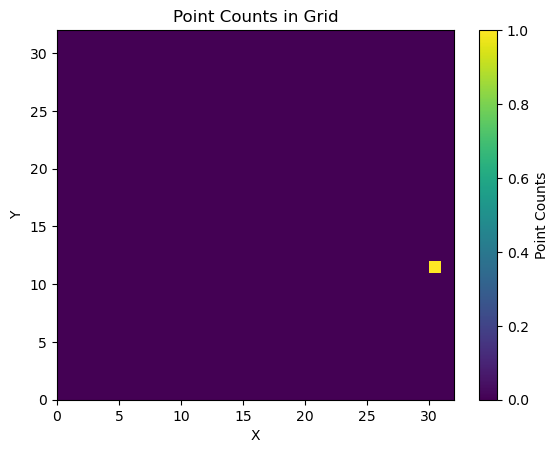

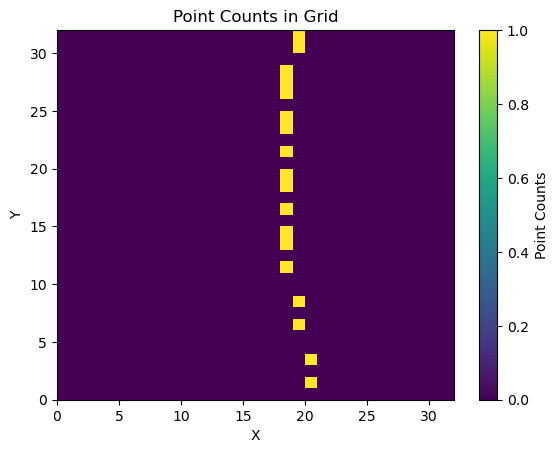

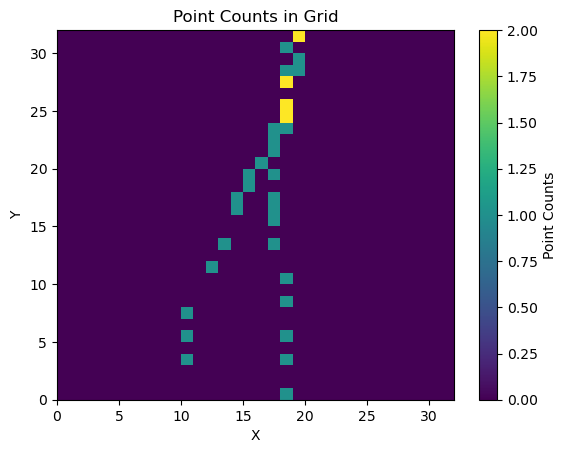

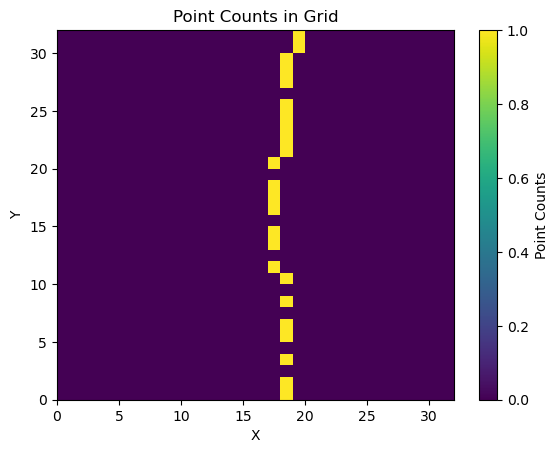

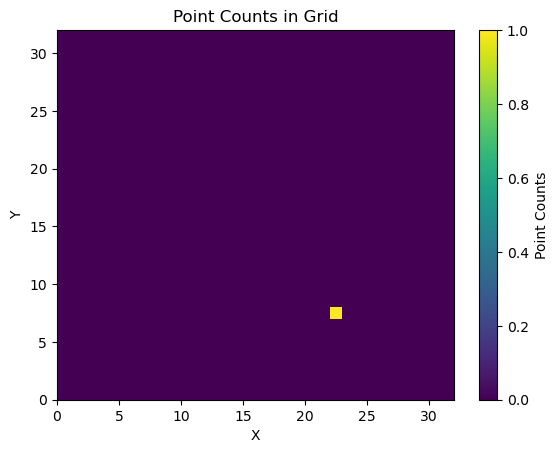

In [5]:
# Sanity check data

# Function to visualise processed data

ymax, xmax = pd.DataFrame(AIS_snapshots[0]).shape # rows, cols

def plot_grid(grid_df, xmin, xmax, ymin, ymax):
    '''Function to take arbitrary sized dataframe of spatial coordinates and plot'''
    # Create a meshgrid for the cell coordinates
    x_grid, y_grid = np.meshgrid(np.linspace(xmin, xmax, grid_df.shape[1] + 1),
                                 np.linspace(ymin, ymax, grid_df.shape[0] + 1))

    # Plot the cell counts as a heatmap
    plt.pcolormesh(x_grid, y_grid, grid_df.values)
    plt.colorbar(label='Point Counts')  # Add colorbar with label

    # Set axis labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Point Counts in Grid')

    # Show the plot
    plt.show()

for i in range(0,5):
    plot_grid(pd.DataFrame(AIS_snapshots[i]), 0, xmax, 0, ymax)

In [6]:
# flatten grids for filtering
AIS_snapshots_2d = AIS_snapshots.reshape(AIS_snapshots.shape[0], -1)

# put nparray back to df
train = pd.DataFrame(AIS_snapshots_2d)

# drops rows with nans
train = train.dropna()


In [7]:
### Filter *Training Data* - these are set in config section

# get rid of all zero examples and nans
# this will remove 'real' situations where there are no tranmissions
if remove_blank_snapshots == 'yes':
    train = train.loc[~(train == 0).all(axis=1)]


# apply ceiling to reduce stationary hotspots
# this will remove counts so snapshot is binary
if binary_counts == 'yes':
    train = np.clip(train, 0, 1)

In [8]:
# Scale the training data

# Transform the data to log scale
train = np.log(1. + train).values

# Create Scaler instance to fix between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler to the data
scaler.fit(train)

# Transform the data
train = scaler.transform(train)

# back to df
train = pd.DataFrame(train)

# Reshape image in 3 dimensions (height = 32px, width = 32px , chanel = 1)
train = train.values.reshape(-1,num_cells_x,num_cells_y,1)

print('Training Images', train.shape)

Training Images (159302, 32, 32, 1)


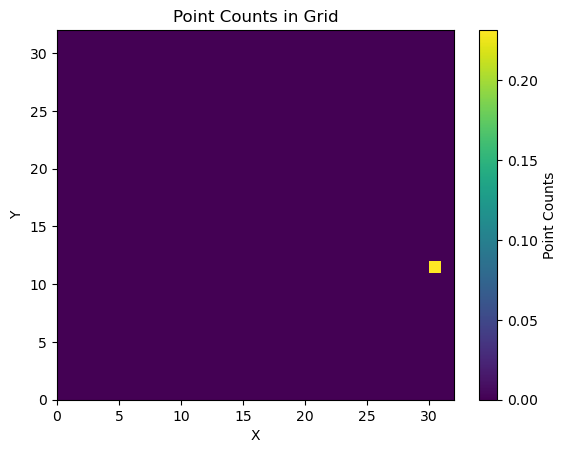

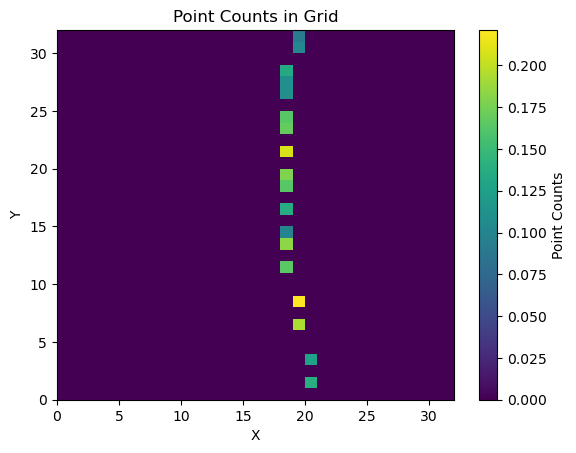

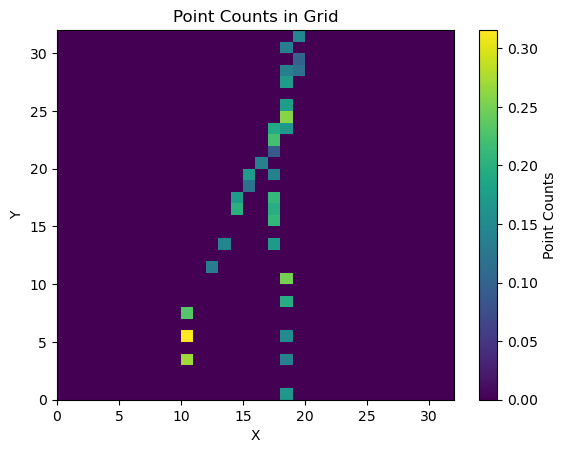

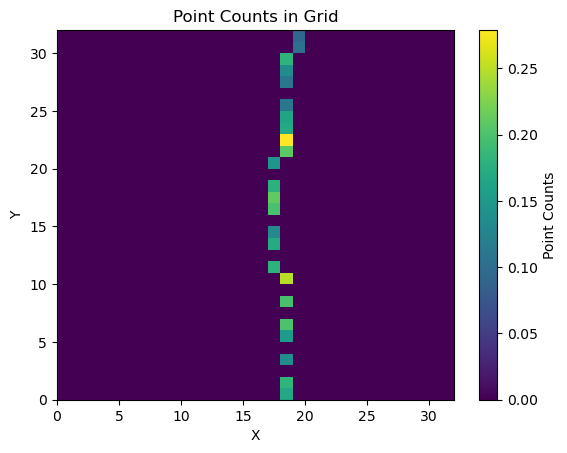

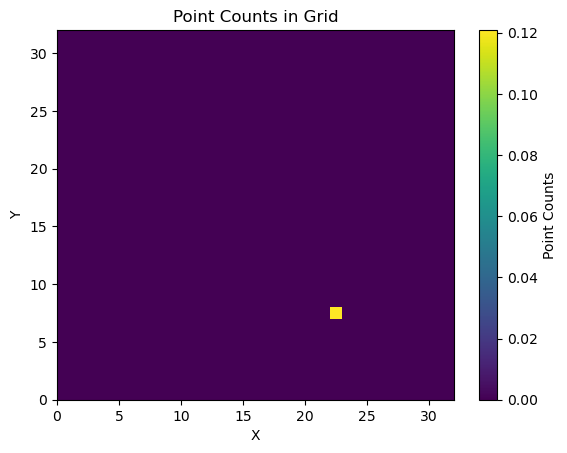

In [9]:
for i in range(0,5):
    plot_grid(pd.DataFrame(np.squeeze(train[i])), 0, xmax, 0, ymax)

In [10]:
# Make a train, val, and test set. NB default is to shuffle data
X_train, X_test = train_test_split(train, test_size=0.4, random_state=42)
X_val, X_test = train_test_split(X_test, test_size=0.5, random_state=42)
print('Training Images', X_train.shape,'Validation Images', X_val.shape, 'Testing Images', X_test.shape)

Training Images (95581, 32, 32, 1) Validation Images (31860, 32, 32, 1) Testing Images (31861, 32, 32, 1)


In [11]:
# Paramters for VAE - this is not optimised!
batch_size = 256
original_shape = train.shape[1:]
original_dim = np.prod(original_shape)
latent_dim = 128 # 64 seems to be enough
large_dim = 512
intermediate_dim = 256
final_dim = 128
epochs = 500 # let early stopping conclude training 
epsilon_std = 1.0 

In [12]:
# Encoder layers
in_layer = Input(shape=original_shape)
x = Flatten()(in_layer)
h = Dense(large_dim, activation='relu')(x)
h = Dense(intermediate_dim, activation='relu')(h)
h = Dense(final_dim, activation = 'relu')(h)

# Latent space
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

# Latent space sampler
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder layers
decoder_f = Dense(final_dim, activation='relu')
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_i = Dense(large_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')

# Decoder model
f_decoded = decoder_f(z)
h_decoded = decoder_h(f_decoded)
i_decoded = decoder_i(h_decoded)
x_decoded_mean = decoder_mean(i_decoded)
x_decoded_snapshot = Reshape(original_shape)(x_decoded_mean)



Metal device set to: Apple M1 Pro


2023-08-13 12:44:06.758961: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-13 12:44:06.759133: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
# instantiate VAE model
vae = Model(in_layer, x_decoded_snapshot)

# Compute VAE loss
cross_ent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(cross_ent_loss + kl_loss)

# Construct model
vae.add_loss(vae_loss)

# set optimiser
vae.compile(optimizer='adam')

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# show model (uncomment)
#vae.summary()

In [14]:
# set steps so that all data is used in each epoc
steps_per_epoch = train.shape[0]//batch_size
# train model
history = vae.fit(X_train,
        shuffle=True,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        batch_size=batch_size,
        callbacks=[early_stopping],
        validation_data=(X_val, None))

Epoch 1/500


2023-08-13 12:44:07.342333: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-08-13 12:44:07.698515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


621/622 [============================>.] - ETA: 0s - loss: 21.7688

2023-08-13 12:44:16.374251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


622/622 [==============================] - 10s 15ms/step - loss: 21.7560 - val_loss: 14.0711
Epoch 2/500
622/622 [==============================] - 8s 14ms/step - loss: 13.7633 - val_loss: 12.6851
Epoch 3/500
622/622 [==============================] - 8s 13ms/step - loss: 12.0800 - val_loss: 11.8456
Epoch 4/500
622/622 [==============================] - 8s 13ms/step - loss: 11.5653 - val_loss: 11.4360
Epoch 5/500
622/622 [==============================] - 8s 13ms/step - loss: 11.3124 - val_loss: 11.2499
Epoch 6/500
622/622 [==============================] - 8s 13ms/step - loss: 11.0336 - val_loss: 10.9364
Epoch 7/500
622/622 [==============================] - 8s 13ms/step - loss: 10.7325 - val_loss: 10.6071
Epoch 8/500
622/622 [==============================] - 8s 13ms/step - loss: 10.3885 - val_loss: 10.3612
Epoch 9/500
622/622 [==============================] - 8s 13ms/step - loss: 10.2174 - val_loss: 10.1960
Epoch 10/500
622/622 [==============================] - 8s 13ms/step - loss

In [15]:
# Calling `save('my_model.keras')` creates a zip archive `my_model.keras`.
vae.save('CGT_180_jan19_mar23_Cont_128D.keras')

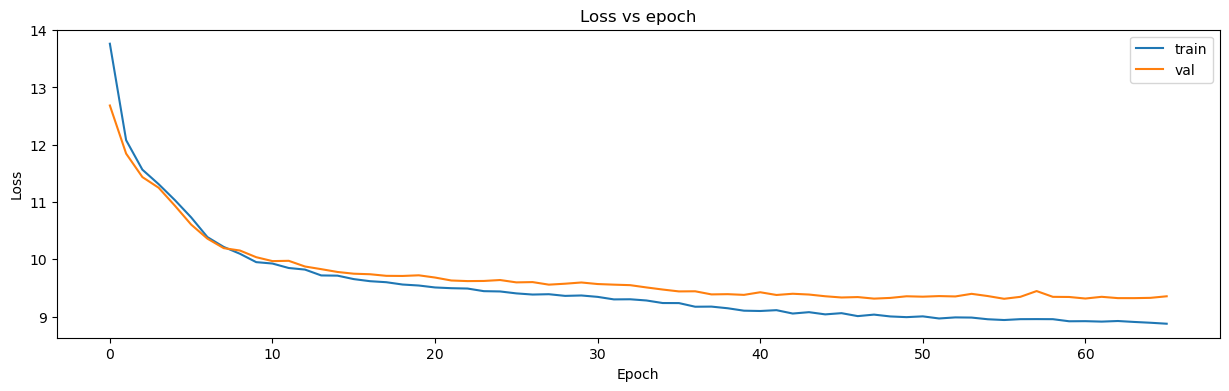

In [16]:
# Plot the learning curve

fig = plt.figure(figsize=(15, 4))
# leave out fist value form plots as they are very high
plt.plot(history.history['loss'][1:], label='train') 
plt.plot(history.history['val_loss'][1:], label='val')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs epoch")
plt.legend()

plt.show()

Build a model to project inputs on the latent space

106/374 [=======>......................] - ETA: 0s

2023-08-13 12:52:44.263665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


374/374 [==============================] - 1s 1ms/step


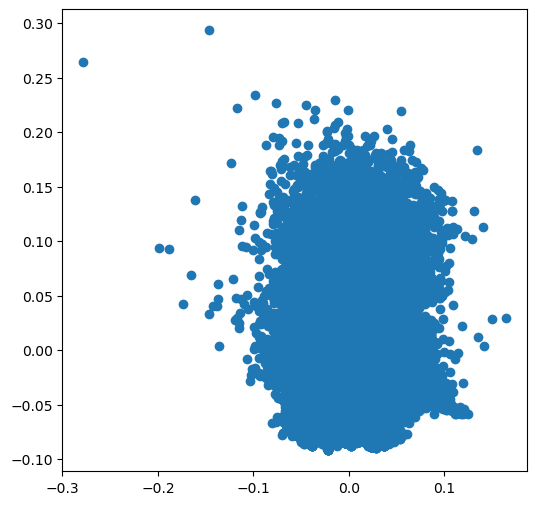

In [17]:
# look at latent space encodings (this version is without labels)

encoder = Model(in_layer, z_mean)
# display a 2D plot of the digit classes in the latent space
train_encoded = encoder.predict(X_train, batch_size=batch_size)

plt.figure(figsize=(6, 6))
plt.scatter(train_encoded[:, 0], train_encoded[:, 1])
# Uncomment below if labels are required
# plt.scatter(X_test_encoded[:, 0], X_test_encoded[:, 1], c=Y_test)
# plt.colorbar()
plt.show()

In [18]:
### Analysis settings

### Idea is that we can detect certain type of anomaly by filering know ones
### e.g. super low errors are anomalous in that they tend to be stationary vessels with 1 or 2 counts...
### ... at least in the case of vessel specific trajectories in 30 min window

# set analysis data set
analysis_data = X_test

# set number of examples from best/worst/median scores
n_examples = 50

# normalise error by number of non-zero cells in snapshot
# (majority of cells in an image have zero counts so skew niave scorer)
normalise_errors = 'yes'

# set the number of cells that constitutes a stationary vessel

n_stat_cells = 5
    
if remove_stationary_vessels == 'yes':
    mask = np.count_nonzero(analysis_data, axis=(1, 2)) > n_stat_cells

    # Remove the elements with only one non-zero element
    analysis_data = analysis_data[mask[:,0]]

 31/104 [=======>......................] - ETA: 0s

2023-08-13 12:52:45.335379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


104/104 [==============================] - 0s 4ms/step


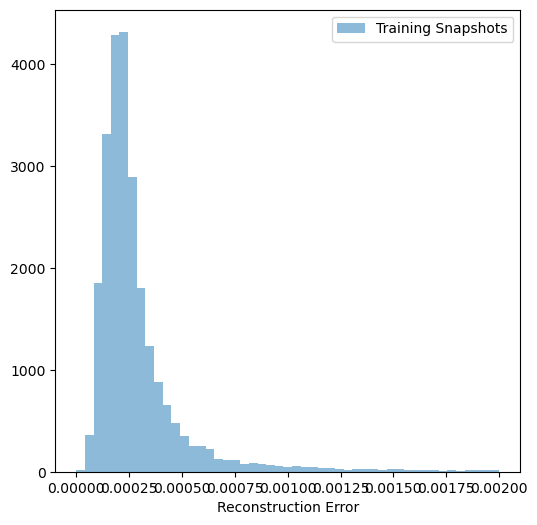

In [19]:
# Plot the reconstruction losses
model_mse = lambda x: np.mean(np.square(x-vae.predict(x, batch_size = batch_size)), (1,2,3))
fig, ax1 = plt.subplots(1,1, figsize = (6,6))
ax1.hist(model_mse(analysis_data), bins = np.linspace(0, 0.002, 50), 
         label = 'Training Snapshots', density = True, alpha = 0.50)
ax1.legend()
ax1.set_xlabel('Reconstruction Error');

104/104 [==============================] - 0s 3ms/step


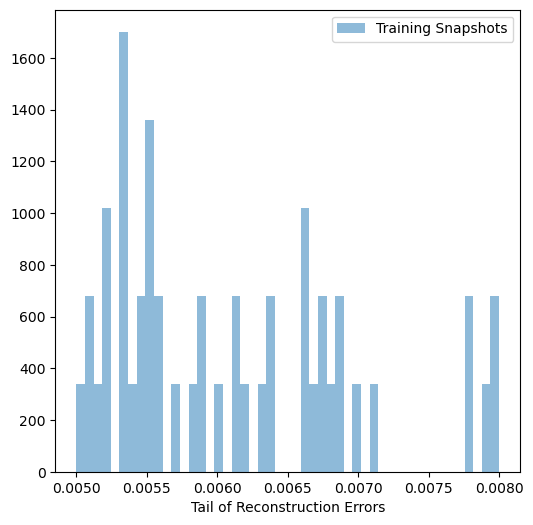

Number of exaples in analysis data set is: 26560


In [20]:
model_mse = lambda x: np.mean(np.square(x-vae.predict(x, batch_size = batch_size)), (1,2,3))
fig, ax1 = plt.subplots(1,1, figsize = (6,6))
ax1.hist(model_mse(analysis_data), bins = np.linspace(0.005, .008, 50), 
         label = 'Training Snapshots', density = True, alpha = 0.50)
ax1.legend()
ax1.set_xlabel('Tail of Reconstruction Errors');
plt.show()

# info for next cell:
print("Number of exaples in analysis data set is:",analysis_data.shape[0] )

In [21]:
# Analysis: calculate errors on analysis set
# set percentage of analysis set to test

test_pct = 0.6
errors = []
error_index = []
best_index = []
med_index = []

for i in range(0,int(analysis_data.shape[0]*test_pct)):
    x = analysis_data[i]
    if normalise_errors == 'yes':
        # count non-zero cells
        nz_count = np.count_nonzero(x)
        # MAE
        re = np.mean(np.sqrt(np.square(x-vae.predict(x, batch_size=256, verbose = 0))))
        # MAE adjusted for number of non-zero cells
        errors.append(re/nz_count)
    else:
        # MAE of errors in all cells per snapshot
        re = re = np.mean(np.sqrt(np.square(x-vae.predict(x, verbose = 0))))
        errors.append(re)
      

2023-08-13 12:52:46.868230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [22]:
n_examples = 50

In [23]:
# Analysis: find examples of best, worst and typical reconstriction losses

# get indices of sorted errors
sorted_errors = np.argsort(errors)
# highest errors
error_index = sorted_errors[-n_examples:]
worst_rec_errs =  analysis_data[error_index]
# lowest errors
best_index = sorted_errors[:n_examples]
best_rec_errs =  analysis_data[best_index]
# median errors
middle_start = len(errors) // 2 - n_examples // 2
med_index = sorted_errors[middle_start:middle_start+n_examples]
med_rec_errs =  analysis_data[med_index]

### Compare Inputs with reconstructions

******** Worst Reconstruction Errors *********


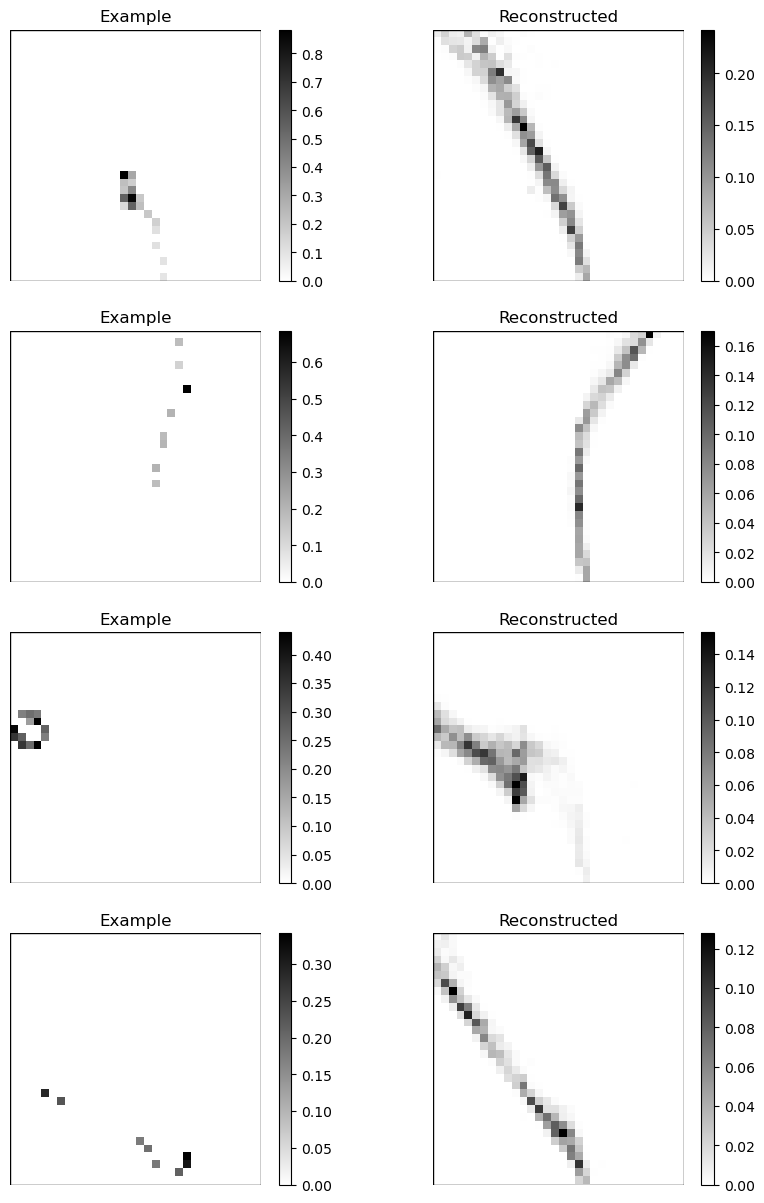

******** Median Reconstruction Errors *********


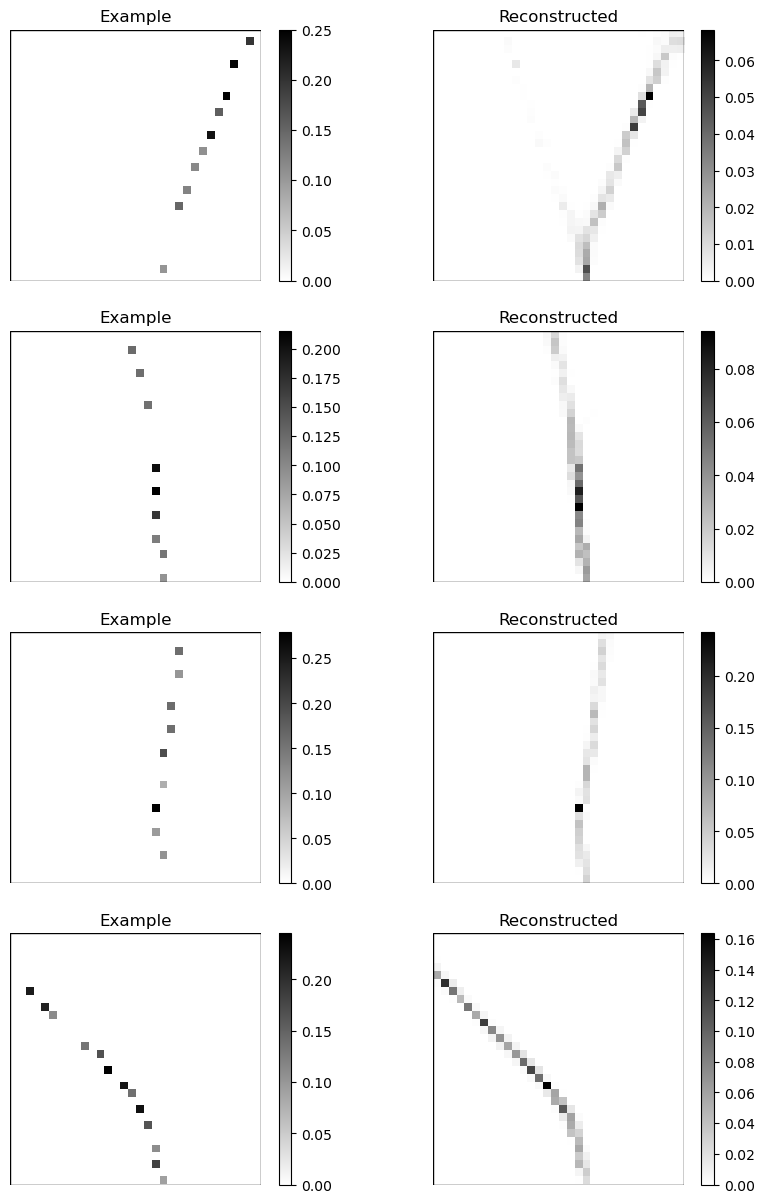

In [24]:
# n_examples = 25

# # set up subplots
# def compare_input_recon(data, n_examples):
#     fig, m_axs = plt.subplots(n_examples,2, figsize=(10, 100))
#     [c_ax.axis('off') for c_ax in m_axs.ravel()]
#     # get original snapshots and predictions
#     for i, (axa_in, axa_vae) in enumerate(m_axs):
#         axa_in.imshow(data[i,:,:,0])
#         axa_in.set_title('Example')
#         axa_vae.imshow(vae.predict(data[i:i+1], verbose = 0)[0,:,:,0])
#         axa_vae.set_title('Reconstructed')

import matplotlib.patches as patches
n_examples = 4
# set up subplots
def compare_input_recon(data, n_examples):
    fig, m_axs = plt.subplots(n_examples, 2, figsize=(10, 15))
    [c_ax.axis('off') for c_ax in m_axs.ravel()]
    # get original snapshots and predictions
    for i, (axa_in, axa_vae) in enumerate(m_axs):
        im_in = axa_in.imshow(data[i, :, :, 0], cmap='gray_r')
        axa_in.set_title('Example')
        
        im_vae = axa_vae.imshow(vae.predict(data[i:i+1], verbose=0)[0, :, :, 0], cmap='gray_r')
        axa_vae.set_title('Reconstructed')

        # Add a black border around the plots
        border = patches.Rectangle((0, 0), 1, 1, transform=axa_in.transAxes, color='black', linewidth=1, fill=False)
        axa_in.add_patch(border)

        border = patches.Rectangle((0, 0), 1, 1, transform=axa_vae.transAxes, color='black', linewidth=1, fill=False)
        axa_vae.add_patch(border)

        # Add color scale bar to the right of the plots
        fig.colorbar(im_in, ax=axa_in)
        fig.colorbar(im_vae, ax=axa_vae)

print("******** Worst Reconstruction Errors *********")
compare_input_recon(worst_rec_errs,n_examples)
plt.show()
# print("******** Best Reconstruction Errors *********")
# compare_input_recon(best_rec_errs,n_examples)
# plt.show()
print("******** Median Reconstruction Errors *********")
compare_input_recon(med_rec_errs,n_examples)
plt.show()

2/2 [==============================] - 0s 4ms/step


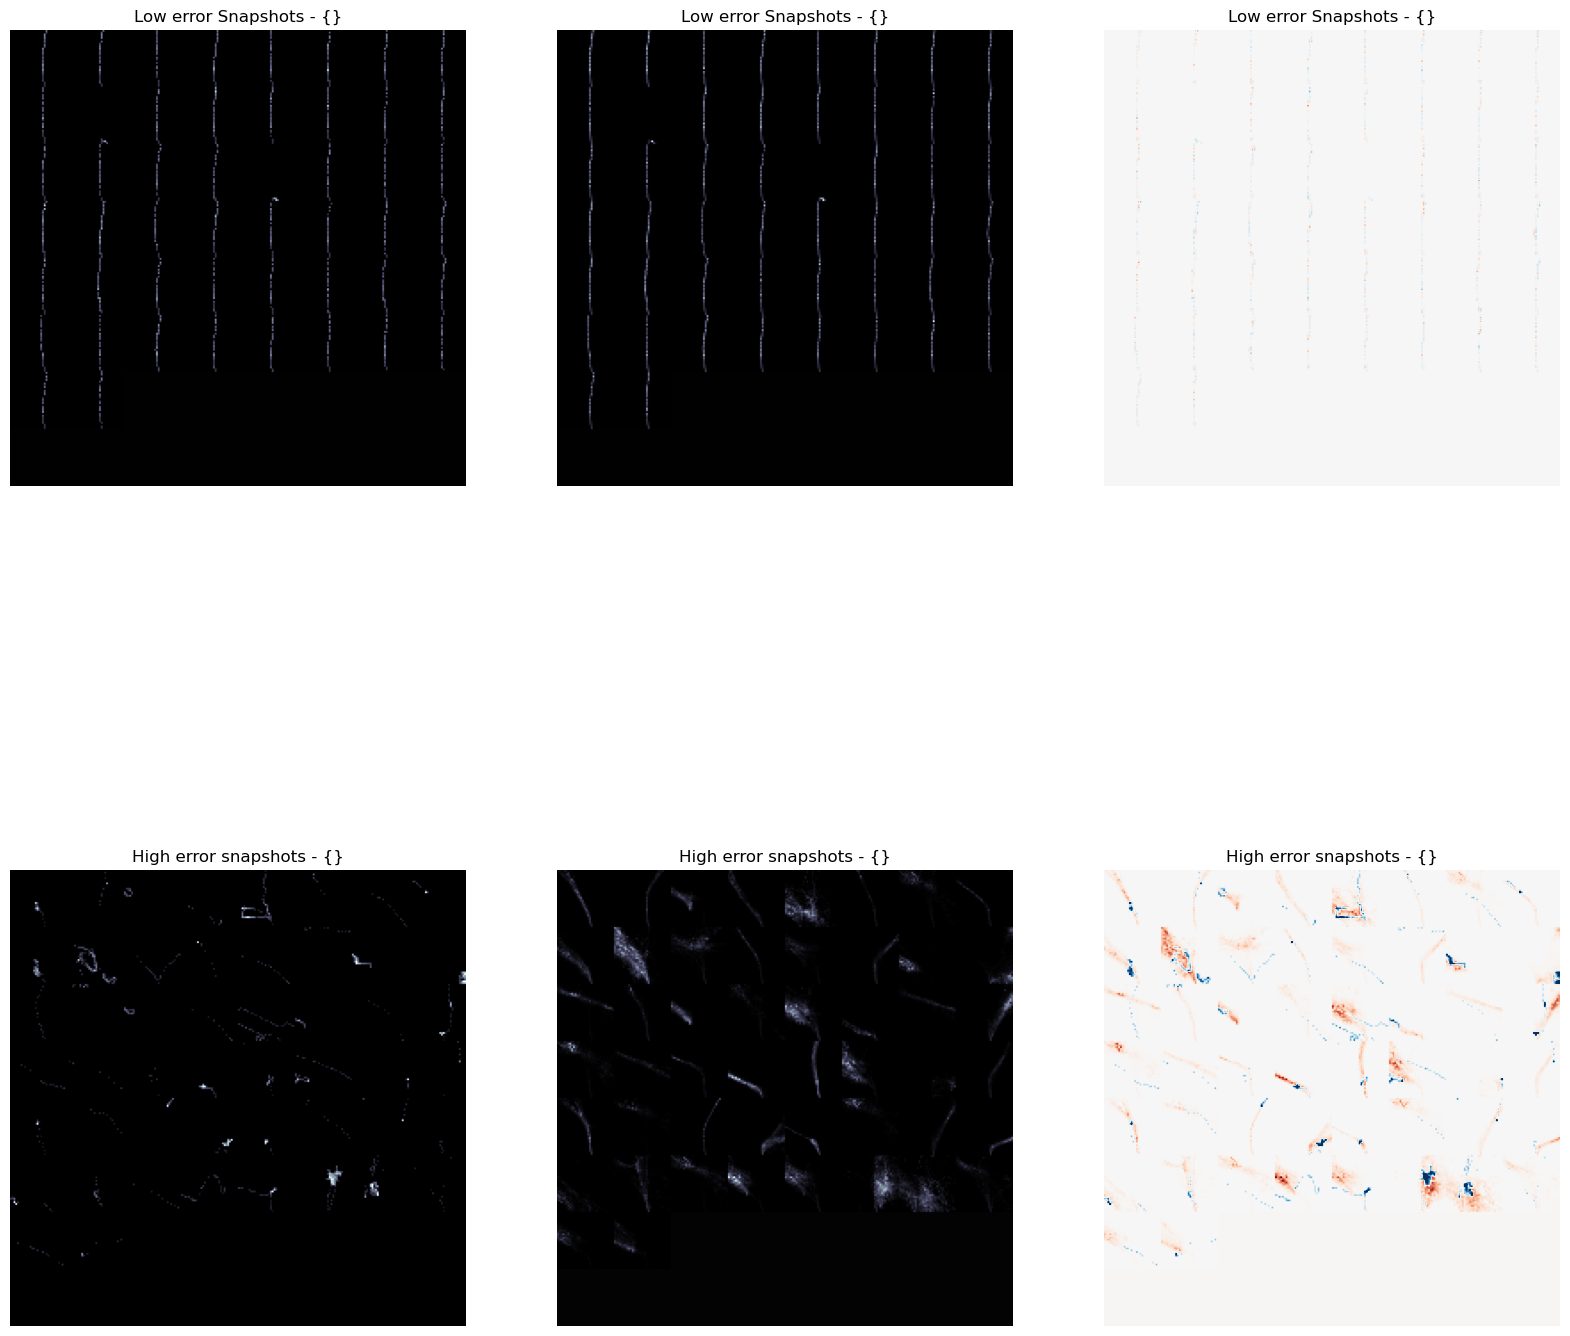

In [25]:
fig, m_axs = plt.subplots(2,3, figsize=(20, 20))
ss_worst = analysis_data[error_index] # high error snapshots
ss_best = analysis_data[best_index] # low error snapshots

for (ax_low_err, ax_high_err), (plt_name, plt_func) in zip(m_axs.T, [('Input', lambda x: x), 
                                                   ('VAE', vae.predict),
                                                    ('Error', lambda x: x-vae.predict(x))
                                                   ]):
    plt_high_error = plt_func(ss_worst)
    if plt_high_error.min()<0:
        plt_kwargs = dict(vmin = -0.5, vmax = 0.5, cmap = 'RdBu')
    else:
        plt_kwargs = dict(cmap = 'bone')
    ax_high_err.imshow(montage(plt_high_error[:,:,:,0]), **plt_kwargs)
    ax_high_err.set_title('High error snapshots - {}')
    ax_high_err.axis('off')
    ax_low_err.imshow(montage(plt_func(ss_best)[:,:,:,0]), **plt_kwargs)
    ax_low_err.set_title('Low error Snapshots - {}')
    ax_low_err.axis('off')



In [26]:

np.sum(best_rec_errs[0])

5.532666372188993